# LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
df = pd.read_excel('/kaggle/input/dataflow/final.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

In [4]:
df.drop(columns=["COGS", "Product", "State", "Unnamed: 0","Category", "Segment", "City", "Region", "District"])

,ProductID,Zip,Units,Revenue
Date,,,,
2010-07-04,604,47946,1,5767.65
2010-07-04,1859,20008,1,1877.40
2010-07-04,485,44830,1,10218.60
2010-07-04,485,55008,1,10218.60
2010-07-04,485,47380,1,10218.60
...,...,...,...,...
2022-07-01,2269,21012,1,4718.70
2022-07-01,2269,48313,1,4718.70
2022-07-01,465,40299,1,14174.37


In [ ]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    denom = np.where(actual == 0, 1, actual)
    mape = np.mean(np.abs((actual - forecast) / denom)) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

In [ ]:
monthly_sales = df['Units'].resample('M').sum()
monthly_revenue = df['Revenue'].resample('M').sum()

train_revenue = monthly_revenue[monthly_revenue.index.year <= 2020]
test_revenue  = monthly_revenue[monthly_revenue.index.year >= 2021]

train_sales = monthly_sales[monthly_sales.index.year <= 2020]
test_sales  = monthly_sales[monthly_sales.index.year >= 2021]

## for revenue

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_revenue.values.reshape(-1, 1))
test_scaled = scaler.transform(test_revenue.values.reshape(-1, 1))

In [ ]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(train_sales.values.reshape(-1, 1))
# test_scaled = scaler.transform(test_sales.values.reshape(-1, 1))

In [ ]:
def create_dataset(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)


In [ ]:
window_size = 12
X_train, y_train = create_dataset(train_scaled, window_size)
# Reshape the data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

val_split = 0.1
val_size = int(len(X_train) * val_split)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_tuner = X_train[:-val_size]
y_train_tuner = y_train[:-val_size]

In [ ]:
def build_model(hp):
    model = Sequential()

    units = hp.Int('units', min_value=16, max_value=256, step=16)
    add_second_layer = hp.Boolean('add_second_layer')
    model.add(LSTM(units, activation='relu',  return_sequences=add_second_layer, input_shape=(window_size, 1)))
    
    if add_second_layer:
        add_third_layer = hp.Boolean('add_third_layer')  
        if add_third_layer:
            model.add(LSTM(units, activation='relu', return_sequences=True))
            model.add(LSTM(units, activation='relu', return_sequences=False))
        else:
            model.add(LSTM(units, activation='relu', return_sequences=False))
    
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='revenue_forecasting'
)

tuner.search_space_summary()

Reloading Tuner from lstm_tuning/revenue_forecasting/tuner0.json
Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
add_second_layer (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
add_third_layer (Boolean)
{'default': False, 'conditions': []}


In [ ]:
tuner.search(X_train_tuner, y_train_tuner, epochs=100, validation_data=(X_val, y_val), batch_size=128)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(best_hps.values)

Trial 10 Complete [00h 00m 17s]
val_loss: 0.008372034411877394

Best val_loss So Far: 0.002329504757653922
Total elapsed time: 00h 03m 14s
Best hyperparameters found:
{'units': 192, 'add_second_layer': True, 'dropout': 0.30000000000000004, 'learning_rate': 0.0034590775156661075, 'add_third_layer': False}


In [ ]:
# tuner.search(X_train_tuner, y_train_tuner, epochs=100, validation_data=(X_val, y_val), batch_size=64)
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Best hyperparameters found:")
# print(best_hps.values)

Best hyperparameters found:
{'units': 192, 'add_second_layer': True, 'dropout': 0.30000000000000004, 'learning_rate': 0.0034590775156661075, 'add_third_layer': False}


In [59]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1810 - val_loss: 0.0106
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1049 - val_loss: 0.0209
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0570 - val_loss: 0.0111
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0858 - val_loss: 0.0142
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1146 - val_loss: 0.0128
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1062 - val_loss: 0.0099
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0875 - val_loss: 0.0089
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0641 - val_loss: 0.0168
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0461 - val_loss: 0.0411
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0596 - val_loss: 0.0454
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0592 - val_loss: 0.0265
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0487 - val_loss

In [ ]:
predictions = []
current_input = train_scaled[-window_size:].flatten()

for i in range(len(test_scaled)):
    x_input = current_input.reshape(1, window_size, 1)
    pred = best_model.predict(x_input, verbose=0)
    predictions.append(pred[0,0])
    current_input = np.append(current_input[1:], pred[0,0])

predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
test_inv = scaler.inverse_transform(test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
r2 = r2_score(test_inv, predictions_inv)
mape = np.mean(np.abs((test_inv - predictions_inv) / test_inv)) * 100

print(f"Best LSTM Model Performance: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%, R² = {r2:.2f}")


Best LSTM Model Performance: RMSE = 943.05, MAPE = 34.59%, R² = 0.62


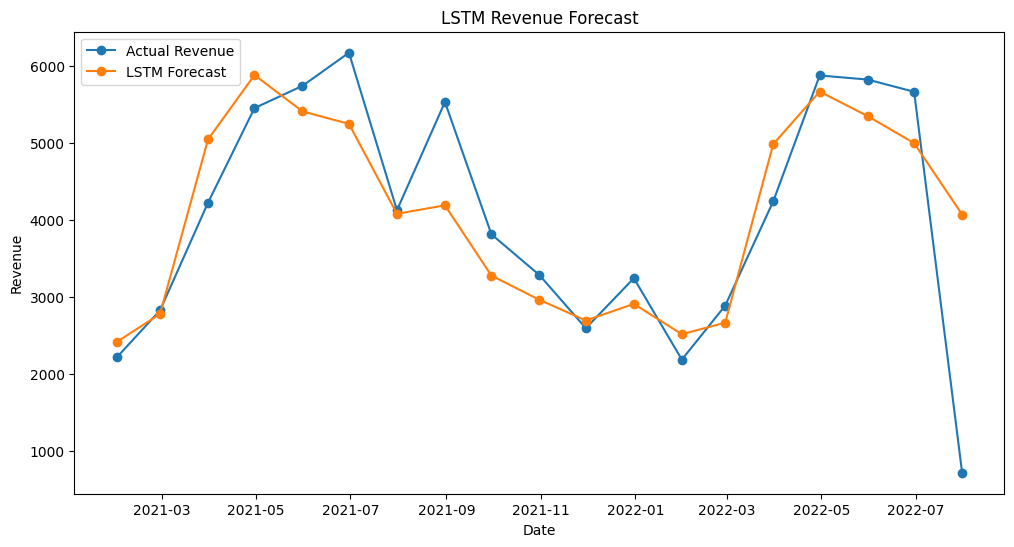

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_revenue.index, test_inv, label='Actual Revenue', marker='o')
plt.plot(test_revenue.index, predictions_inv, label='LSTM Forecast', marker='o')
plt.title('LSTM Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


## For units

Rerun the whole process

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_sales.values.reshape(-1, 1))
test_scaled = scaler.transform(test_sales.values.reshape(-1, 1))


window_size = 12
X_train, y_train = create_dataset(train_scaled, window_size)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

val_split = 0.1
val_size = int(len(X_train) * val_split)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_tuner = X_train[:-val_size]
y_train_tuner = y_train[:-val_size]


tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='revenue_forecasting'
)

tuner.search_space_summary()

tuner.search(X_train_tuner, y_train_tuner, epochs=100, validation_data=(X_val, y_val), batch_size=64)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(best_hps.values)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))



Reloading Tuner from lstm_tuning/revenue_forecasting/tuner0.json
Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
add_second_layer (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
add_third_layer (Boolean)
{'default': False, 'conditions': []}
Best hyperparameters found:
{'units': 192, 'add_second_layer': True, 'dropout': 0.30000000000000004, 'learning_rate': 0.0034590775156661075, 'add_third_layer': False}
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1734 - val_loss: 0.0094
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1074 - val_loss: 0.0257
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0536 - val_loss: 0.0099
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0778 - val_loss: 0.0128
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1048 - val_loss: 0.0119
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0963 - val_loss: 0.0097
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0747 - val_loss: 0.0089
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0626 - val_loss: 0.0155
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0508 - val_loss: 0.0336
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0582 - val_loss: 0.0377
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0590 - val_loss: 0.0215
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0478 - val_loss: 0.0124
Epo

Best LSTM Model Performance: RMSE = 1075.12, MAPE = 32.36%, R² = 0.51


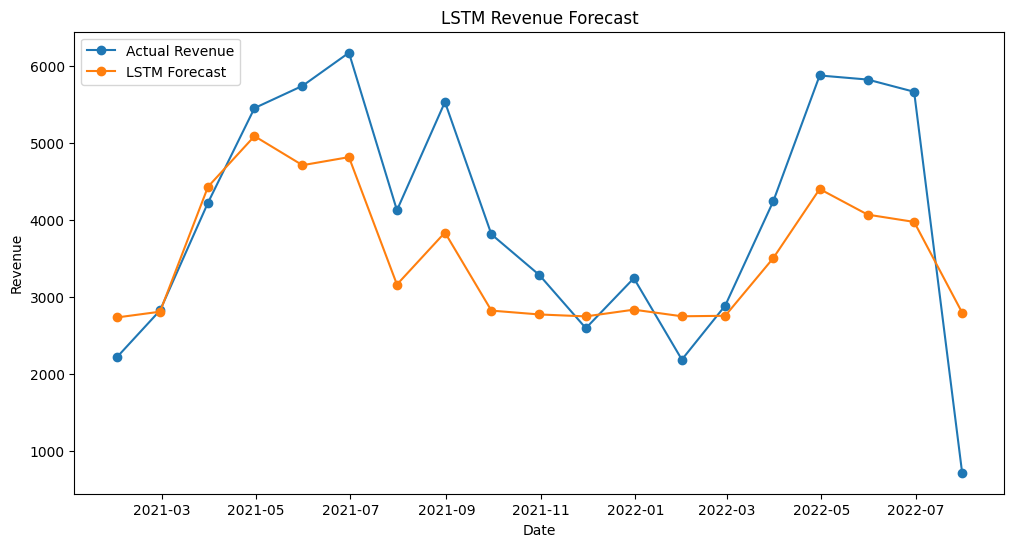

In [ ]:
predictions = []
current_input = train_scaled[-window_size:].flatten()

for i in range(len(test_scaled)):
    x_input = current_input.reshape(1, window_size, 1)
    pred = best_model.predict(x_input, verbose=0)
    predictions.append(pred[0,0])
    current_input = np.append(current_input[1:], pred[0,0])

predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
test_inv = scaler.inverse_transform(test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
r2 = r2_score(test_inv, predictions_inv)
mape = np.mean(np.abs((test_inv - predictions_inv) / test_inv)) * 100

print(f"Best LSTM Model Performance: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%, R² = {r2:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(test_revenue.index, test_inv, label='Actual Revenue', marker='o')
plt.plot(test_revenue.index, predictions_inv, label='LSTM Forecast', marker='o')
plt.title('LSTM Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


## Construct final LSTM

In [19]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [20]:
def create_dataset(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

In [23]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    denom = np.where(actual == 0, 1, actual)
    mape = np.mean(np.abs((actual - forecast) / denom)) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

In [22]:
def lstm_forecasting(series_name, train_series, test_series, window_size=12, epochs=50, batch_size=16):
    print(f"\n--- {series_name} LSTM Forecasting ---")

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_series.values.reshape(-1, 1))
    
    X_train, y_train = create_dataset(train_scaled, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(192, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(192, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    predictions = []
    current_input = train_scaled[-window_size:].flatten()  
    for i in range(len(test_series)):
        X_input = current_input.reshape(1, window_size, 1)
        pred = model.predict(X_input, verbose=0)
        predictions.append(pred[0,0])
        current_input = np.append(current_input[1:], pred[0,0])
    
    predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()
    
    
    
    rmse, mape, r2 = compute_metrics(test_series.values, predictions_inv)
    print(f"{series_name} LSTM: RMSE={rmse:.2f}, MAPE={mape:.2f}%, R²={r2:.2f}")
    
    plt.figure(figsize=(12,6))
    plt.plot(train_series.index, train_series, label="Training Data")
    plt.plot(test_series.index, test_series, label="Actual Test Data", color='gray')
    plt.plot(test_series.index, predictions_inv, label="LSTM Forecast", color='red')
    plt.title(f"{series_name} LSTM Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel(series_name)
    plt.legend()
    plt.show()
    
    return predictions_inv, (rmse, mape, r2)



>>> Revenue LSTM Forecasting

--- Revenue LSTM Forecasting ---
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1659
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1191
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0743
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0572
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0693
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0534
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0550
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0519
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0557
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0572
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0481
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0477
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0466
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0531
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0487
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━

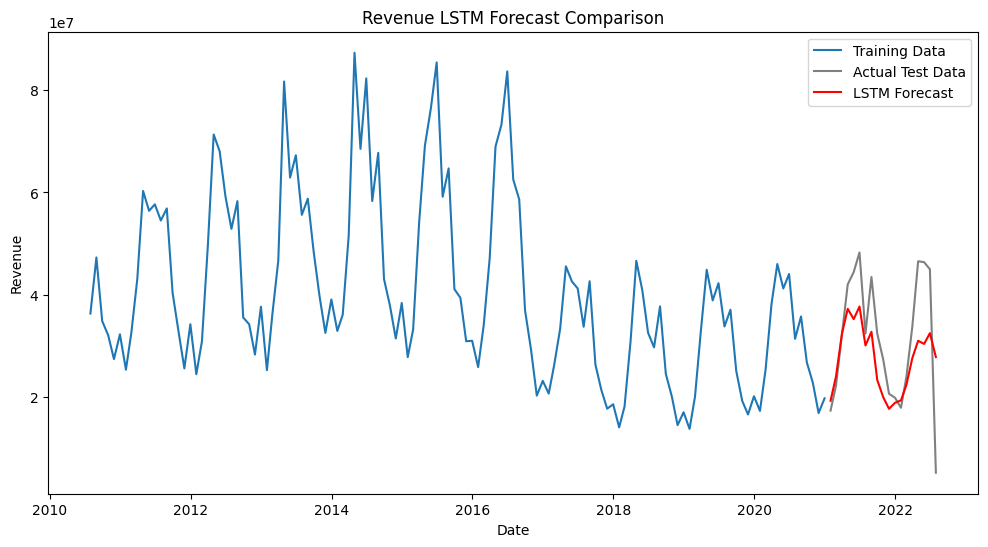

In [44]:
print("\n>>> Revenue LSTM Forecasting")
lstm_predictions_revenue, lstm_metrics_revenue = lstm_forecasting("Revenue", train_revenue, test_revenue,window_size=12, epochs=100, batch_size=64)



>>> Revenue LSTM Forecasting

--- Revenue LSTM Forecasting ---
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2179
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1902
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1645
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1402
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1120
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0815
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0553
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0461
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0596
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0735
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0622
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0517
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0447
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0447
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0474
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━

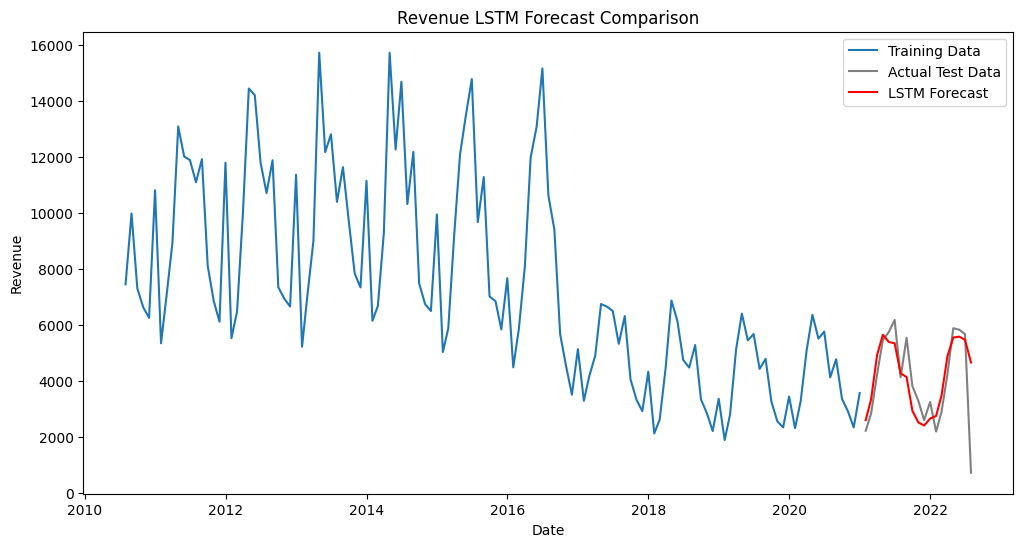

In [ ]:

print("\n>>> Revenue LSTM Forecasting")
lstm_predictions_revenue, lstm_metrics_revenue = lstm_forecasting("Revenue", train_revenue, test_revenue,window_size=12, epochs=200, batch_size=128)



>>> Sales (Units) LSTM Forecasting

--- Sales (Units) LSTM Forecasting ---
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2186
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1939
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1722
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1482
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1220
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0955
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0637
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0456
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0562
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0727
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0726
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0482
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0438
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0455
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0486
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━

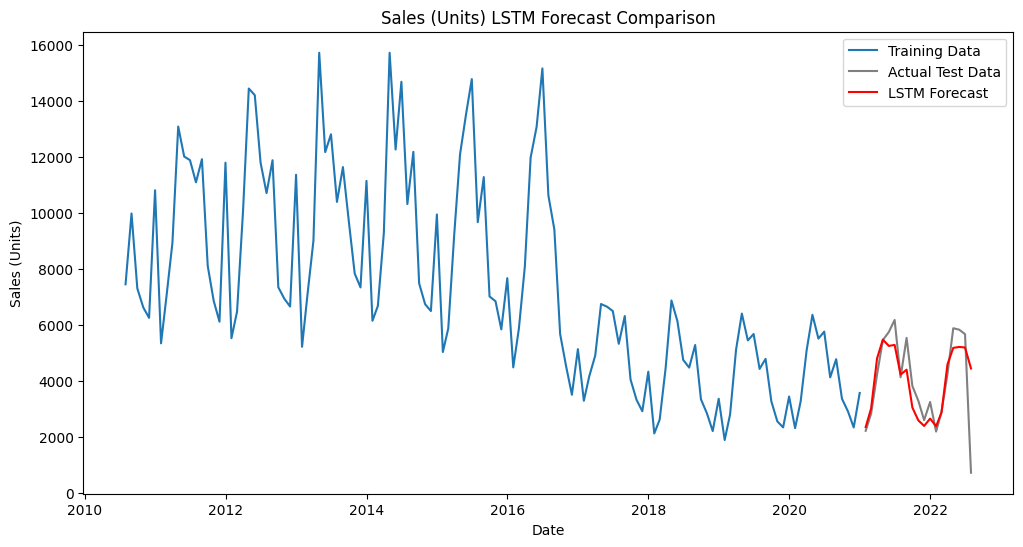

In [ ]:
print("\n>>> Sales (Units) LSTM Forecasting")
lstm_predictions_sales, lstm_metrics_sales = lstm_forecasting("Sales (Units)", train_sales, test_sales, window_size=12, epochs=200, batch_size=128)